In [9]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from PIL import Image
import scipy.sparse as sp
import pandas as pd
from numpy.random import *

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [10]:
from torchvision import models, transforms, datasets
import torch
torch.cuda.is_available()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader

In [11]:
transform = transforms.Compose([
    #transforms.CenterCrop(724),
    transforms.Resize((224, 224)),
    # you can add other transformations in this list
    transforms.ToTensor()
])

In [12]:
batch_size = 16
num_epoch = 100

In [13]:
trainset = datasets.ImageFolder(root="./pneumonia_data/train5", transform = transform)
validset = datasets.ImageFolder(root="./pneumonia_data/valid", transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers=4)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, pin_memory = True, num_workers=4)

In [14]:
model = models.resnet50(pretrained=True).to(device)
num_features = model.fc.in_features
#print(num_features)

# fc層を置き換える
model.fc = nn.Linear(num_features, 1).to(device)  #binary classifierなので出力は一つでよい

In [15]:
#1epoch分の、train と valid用の関数
def train(dataloader, is_train=True):
    
    loss_sum = 0
    accuracy = 0
    
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    
    #以下、directoiryの配置により、abnorm(=pos)をラベル0、norm(=neg)をラベル１と仮定する
    

    for batch_id, (inputs, targets) in enumerate(dataloader):

        #model.train() or model.eval()
        model.train(is_train)

        #ここでbreakすれば数は限れる。

        inputs  = inputs.to(device)
        targets = targets.to(device)
        targets = targets.float()

        outputs = model(inputs)
        outputs = outputs.squeeze()  #reshaping
        
        #追加
        predicted_neg = (outputs > 0).cpu()
        predicted_pos = (outputs <= 0).cpu()
        real_neg = targets.cpu()
        real_pos = 1 - targets.cpu()        
        tp += torch.sum(predicted_pos * real_pos)
        tn += torch.sum(predicted_neg * real_neg)
        fp += torch.sum(predicted_pos * real_neg)        
        fn += torch.sum(predicted_neg * real_pos)
        
        #p()=0.5のケースで区切る。i.e. 出力が>0かどうかでラベルを区別。
        # >0 ならラベル１に、<0ならラベル０に対応させ、正解と比較。
        #deviceの項を取り除くため、.cpu()してる
        accuracy += torch.sum(((outputs > 0).cpu()) == targets.cpu())

        loss = criterion(m(outputs), targets)

        if is_train: #train
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_sum += loss    
        
    loss_ave = loss_sum / (batch_id + 1)

    #torchだと割り算が整数の割り算になってしまうので、適当にnpでやった
    accuracy = accuracy.numpy()
    accuracy = accuracy / ((batch_id + 1) * batch_size)
    
    #追加
    tp = tp.numpy()
    tn = tn.numpy()
    fp = fp.numpy()
    fn = fn.numpy()    
    precision = tp / (tp + fp)
    recall   = tp / (tp + fn)
    dice     = 2*tp / (2*tp + fp + fn)
    #accuracy = (tp + tn) / (tp+tn+fp+fn) #just verification. remove soon. 
    
    return loss_ave, accuracy, precision, recall, dice

In [16]:
#deviceにのっけると速い
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.002)

criterion = nn.BCELoss()
m = nn.Sigmoid()

losses = []
accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(num_epoch):
    
    loss_ave, accuracy, _, _, _ = train(trainloader, is_train=True)        
    losses.append(loss_ave)
    accuracies.append(accuracy)
    
    with torch.no_grad():
        val_loss_ave, val_accuracy, precision, recall, dice = train(validloader, is_train=False)        
        val_losses.append(val_loss_ave)
        val_accuracies.append(val_accuracy)    
    
    print("epoch:{}/{} loss:{:.4f}, accuracy:{:.3f}, val_loss:{:.4f}, val_acc:{:.3f}".format(epoch+1, num_epoch, loss_ave, accuracy, val_loss_ave, val_accuracy))
    print("            precision:{:.3f}, recall:{:.3f}, dice:{:.3f}".format(precision, recall, dice))

epoch:1/100 loss:-13.2020, accuracy:0.492, val_loss:13.5800, val_acc:0.491
            precision:nan, recall:0.000, dice:0.000


/home/yodai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


epoch:2/100 loss:-13.7930, accuracy:0.498, val_loss:13.5800, val_acc:0.491
            precision:nan, recall:0.000, dice:0.000
epoch:3/100 loss:-13.7705, accuracy:0.498, val_loss:13.5800, val_acc:0.491
            precision:nan, recall:0.000, dice:0.000
epoch:4/100 loss:-13.7930, accuracy:0.498, val_loss:13.5800, val_acc:0.491
            precision:nan, recall:0.000, dice:0.000
epoch:5/100 loss:-13.8380, accuracy:0.498, val_loss:13.5800, val_acc:0.491
            precision:nan, recall:0.000, dice:0.000


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/yodai/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-921dcf0f4073>", line 16, in <module>
    loss_ave, accuracy, _, _, _ = train(trainloader, is_train=True)
  File "<ipython-input-15-43ca1f312973>", line 49, in train
    optimizer.step()
  File "/home/yodai/anaconda3/lib/python3.7/site-packages/torch/optim/adam.py", line 107, in step
    p.data.addcdiv_(-step_size, exp_avg, denom)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/yodai/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2039, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Trace

KeyboardInterrupt: 

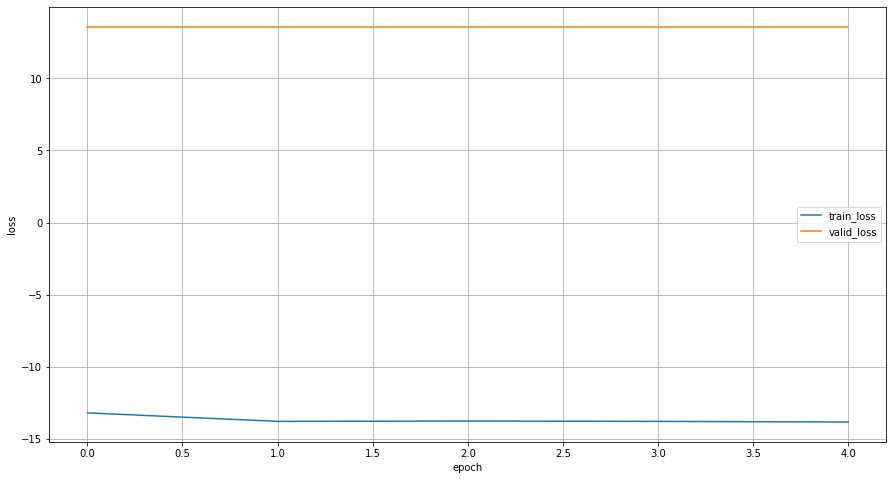

In [18]:
#save_file = 

plt.figure(figsize=(15,8))
plt.plot(losses, label="train_loss")
plt.plot(val_losses, label="valid_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
#plt.savefig('result/Loss_of_rsna_data2_ResNet50_Size224.png')

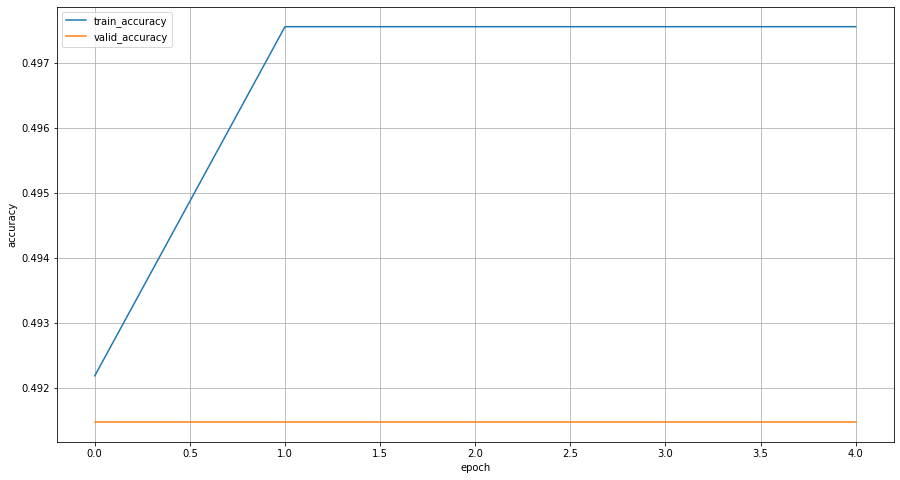

In [19]:
plt.figure(figsize=(15,8))
plt.plot(accuracies, label="train_accuracy")
plt.plot(val_accuracies, label="valid_accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
#plt.savefig('result/Accuracy_of_rsna_data2_ResNet50_Size224.png')

In [7]:
#1epoch分の、train と valid用の関数
def train(dataloader, is_train=True):
    
    loss_sum = 0
    accuracy = 0

    for batch_id, (inputs, targets) in enumerate(dataloader):

        #model.train() or model.eval()
        model.train(is_train)

        #ここでbreakすれば数は限れる。

        inputs  = inputs.to(device)
        targets = targets.to(device)
        targets = targets.float()

        outputs = model(inputs)
        outputs = outputs.squeeze()  #reshaping

        #p()=0.5のケースで区切る。i.e. 出力が>0かどうかでラベルを区別。
        # >0 ならラベル１に、<0ならラベル０に対応させ、正解と比較。
        #deviceの項を取り除くため、.cpu()してる
        accuracy += torch.sum(((outputs > 0).cpu()) == targets.cpu())

        loss = criterion(m(outputs), targets)

        if is_train: #train
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_sum += loss    
        
    loss_ave = loss_sum / (batch_id + 1)

    #torchだと割り算が整数の割り算になってしまうので、適当にnpでやった
    accuracy = accuracy.numpy()
    accuracy = accuracy / ((batch_id + 1) * batch_size)
    
    return loss_ave, accuracy